<a href="https://colab.research.google.com/github/KennyNg-19/colab_nb/blob/main/CS4243template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS4243
## Image Classification

### Three classes: normal, carrying, threat


# TODO:
1. need to somehow load data and potentially use dataloader to split batch
2. a DF ideally contains file names and label

In [ ]:
# !pip install google-colab

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# # %cd /content/drive/My Drive/Colab Notebooks/cs4243_smallest # Kenny Path
# %cd /content/drive/My Drive/cs4243_smallest 
# # QINI path

# !ls

### Import Library

In [2]:
import os
from PIL import Image
import cv2

import pandas as pd
import numpy as np
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from sklearn.utils.class_weight import compute_sample_weight

from random import randint
import random

from tqdm import tqdm

import time

def seed_torch(seed=3):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed) 
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True


# torch.use_deterministic_algorithms(True)
seed_torch()

In [3]:
# gpu setting
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cpu


### Helper Functions

In [4]:
# Class to save the best model while training - "best_model"
class SaveBestModel:
    def __init__(
        self, save_path = "outputs", best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss
        self.save_path = save_path
        # 别忘了创建目录
        if not os.path.exists(save_path):
            !mkdir $save_path
            print(f"create {save_path}/ dir")
            
    def __call__(
        self, current_valid_loss, 
        epoch, model, optimizer, criterion
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{self.save_path}/best_model.pth')
            
def save_model(epochs, model, optimizer, criterion, save_path='outputs'):
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, f'{save_path}/final_model.pth')

In [5]:
# more info for the poster:
plt.style.use('ggplot')

def save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name="", optimizer='', save_path='outputs'):
    # loss
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        train_loss, color='orange', linestyle='-', 
        label='train loss'
    )
    plt.plot(
        valid_loss, color='red', linestyle='-', 
        label='validataion loss'
    )

    fig.suptitle('model:'+model_name+" "+optimizer, fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(f'{save_path}/loss.png')
    
    # accuracy
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        train_acc, color='green', linestyle='-', 
        label='train accuracy'
    )
    plt.plot(
        valid_acc, color='blue', linestyle='-', 
        label='validataion accuracy'
    )
    
    fig.suptitle('model:'+model_name+" "+optimizer, fontsize=20)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(f'{save_path}/accuracy.png')
    

def creat_viz_cm(confusion_matrix, label2class, title, save_path='outputs'):
    plt.figure(figsize=(7, 5))
    plt.suptitle(title, fontsize=15)

    class_names = list(label2class.values())
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=8)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=8)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    print(f"save as {save_path}/{title}_confmat.png")
    plt.savefig(f'{save_path}/{title}_confmat.png')

### Loading the image and preprocessing
Scaling and cropping, image enhancement, transformation to Tensor, normalization

从输入到最后一个卷积特征feature map，就是进行信息抽象的过程，然后就经过全连接层/全局池化层的变换进行分类了，这个feature map的大小，可以是3*3，5*5，7*7等等。在这些尺寸中，如果尺寸太小，那么信息就丢失太严重，如果尺寸太大，信息的抽象层次不够高，计算量也更大，所以7*7的kernel大小是一个最好的平衡。

另一方面，图像从大分辨率降低到小分辨率，降低倍数通常是2的指数次方，所以图像的输入是 kernel size *2的指数次方。

In [6]:
#labels
class2label = {'normal':0, 'carrying':1, 'threat':2}
label2class = {0:'normal', 1:'carrying', 2:'threat'}
classes = list(class2label.keys()) # keep the orders
class_int = list(class2label.values())
classes, class_int


(['normal', 'carrying', 'threat'], [0, 1, 2])

#### generate DataFrame for whole dataset

In [7]:

img_names = [] # ID
targets = [] # labels


# check path locally or Colab
colab_path = "/content/drive/My Drive/cs4243_smallest" # qini path
if os.path.exists(colab_path):
    root_path = colab_path
else:
    root_path='.' # locally

# Mapping all img names & labels, 也是按照 classes顺序， ['normal', 'carrying', 'threat'] [0,1,2]
for class_path in classes:                    
    
    # print(class_path)
    path = os.path.join(root_path, class_path)
    # 加上label_class_path
    # img_names += [ class_path + "/" + img_name for img_name in os.listdir(path)]
    print('here is class:', class_path, len(os.listdir(path)))
    img_names += os.listdir(path)
    # print(os.listdir(self.path))
    targets += [class2label[class_path]] * len(os.listdir(path)) # all labels = 0 or 1 or 2

# idx 完全mapping
assert len(img_names) == len(targets), f'wrong no of all imgs, {len(img_names)}, {len(targets)}'
df = pd.DataFrame({'ID':img_names, 'Label': targets})
df.head()


here is class: normal 1857
here is class: carrying 1535
here is class: threat 1551


,ID,Label
0,A0204754H_20220903_normal_12340.38628_100.png,0
1,0204722_normal_12340.35267_30.png,0
2,0217792_20220904_normal_32520.027375_200.png,0
3,A0199420B_20220822_normal_27680.34381_200.png,0
4,A0190259Y_20220820_normal_10410.47184_100.png,0


In [8]:
# split into df of train / test 
y = df['Label']
X = df


# torch.utils.data.random_split只是随机分，没有按照类别Stratified，比例：1857 ： 1535 ：1551
# train_df, test_df = torch.utils.data.random_split(dataset, [train_size, test_size])

# 按照8:2
train_df, test_df, train_label, test_label = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2,
                                                              random_state=3) 
# test_df, val_df, test_label, val_label = train_test_split(test_df, test_label, stratify=test_label, test_size=0.5)

# 一定要resetindex, 给loader喂进去之前
train_df.reset_index(drop=True, inplace=True)

test_df.reset_index(drop=True, inplace=True)

# test_df, val_df, test_label, val_label = train_test_split(test_df, test_label, stratify=test_label, test_size=0.5)
# val_df.reset_index(drop=True, inplace=True)
# print(val_df.Label.value_counts()/val_df.Label.value_counts().sum())

# check Stratified split, 的class分布
print(train_df.Label.value_counts()/train_df.Label.value_counts().sum())

print(test_df.Label.value_counts()/test_df.Label.value_counts().sum())



0    0.375569
2    0.313859
1    0.310572
Name: Label, dtype: float64
0    0.376138
2    0.313448
1    0.310415
Name: Label, dtype: float64


#### Image preporcess: transform

In [9]:
# ImageNet的 mean & std
# mean=[0.485, 0.456, 0.406]
# std=[0.229, 0.224, 0.225]

# 拿了某一次 split后的train df算的，比起其他数据集的，算更  贴切了
mean = [0.4098, 0.4207, 0.4142]
std = [0.2732, 0.2746, 0.2714]
normalize = transforms.Normalize(mean, std)
# mean, std = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
# normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

resize_H, resized_W = 7*2**5, 7*2**5 # 如果是toTensor前，最后一个transform操作(即输入到模型的input shape)，最好是kerel size, 3/5/7,* 2的指数次方
resize = transforms.Resize([resize_H, resized_W])
# resize = transforms.Resize([resize_H, resized_W],interpolation=torchvision.transforms.InterpolationMode.BILINEAR)

# 7*2**5=224
crop_H, crop_W = 7*2**5, 7*2**5 # 如果是toTensor前，最后一个transform操作(即输入到模型的input shape)，最好是kerel size, 3/5/7,* 2的指数次方
cent_crop = transforms.CenterCrop([crop_H, crop_W])

transformations = transforms.Compose([resize,
                                    #  cent_crop,
                                    transforms.ToTensor(), # Tturn gray level from 0-255 into 0-1
                                    normalize])  #  change 0-1 into (-1, 1)

#### Build Dataset & DataLoader

In [10]:
class CS4243_dataset(Dataset): 
    
    
    def __init__(self, root_path , dataframe, transform=None):
        
        self.label2class = {0:'normal', 1:'carrying', 2:'threat'}
        self.df = dataframe    
        self.transform = transform
        self.root_path = root_path
        
        self.image_paths = self.df['ID'] #image names
        self.labels = self.df['Label']
                

    def __getitem__(self, index):
        
        img_path = self.image_paths[index] # 没有class_file_path
        # print(img_path)
        class_path = self.label2class[self.labels[index]]
        image = Image.open(os.path.join(self.root_path, class_path, img_path))
        
        target = torch.tensor(self.labels[index])
      
        if self.transform != None:
            image = self.transform(image)
          
        return [image, target]
       
    def __len__(self):
        return len(self.df)

In [ ]:
batch_size = 128

train_dataset = CS4243_dataset(root_path, train_df, transform = transformations)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

# val_dataset = CS4243_dataset(root_path, val_df, transform = transformations)
# val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

test_dataset = CS4243_dataset(root_path, test_df, transform = transformations)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, num_workers=2, shuffle = True, pin_memory=True)

for data in train_loader:
    imgs, targets = data
    print(imgs.shape)
    print('labels:', targets, len(targets))
    # test once
    break

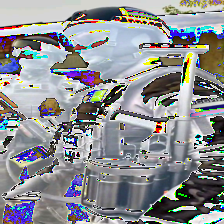

In [ ]:
test = imgs[1]
# plt.imshow( test.permute(1, 2, 0)  )
transforms.ToPILImage()(test) # show tensor BACK to img

### Image Classification Models

Implement image classificaiton by using:
1. VGG as baseline
2. Resnet18
3. Transfer Learning


#### Baseline: CNN from scratch

In [ ]:
# Creating a CNN model
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # === Complete the code (1.5')
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu2 = nn.ReLU()
        self.mp1 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu4 = nn.ReLU()
        self.mp2 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.conv5 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu5 = nn.ReLU()
        self.conv6 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu6 = nn.ReLU()
        self.mp3 = nn.MaxPool2d((2, 2), stride=(2, 2))
        
        self.conv7 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu7 = nn.ReLU()
        self.conv8 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=5, stride=1, padding=1, padding_mode='zeros')
        self.relu8 = nn.ReLU()
        
        self.aap = nn.AdaptiveAvgPool2d(1)
        self.linear = nn.Linear(128, 3)
        # === Complete the code

    def forward(self, x):
        # === Complete the code (1.5')
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.mp1(x)
        
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.conv4(x)
        x = self.relu4(x)
        x = self.mp2(x)
        
        x = self.conv5(x)
        x = self.relu5(x)
        # x = self.conv6(x)
        # x = self.relu6(x)
        x = self.mp3(x)
        
        x = self.conv7(x)
        x = self.relu7(x)
        # x = self.conv8(x)
        # x = self.relu8(x)
        
        x = self.aap(x)
        x = torch.flatten(x, start_dim=1, end_dim=3)
        x = self.linear(x)
        out = x
        # === Complete the code
        return out

# print(cnn_model)

#### Baseline: LeNet-5 from scratch

In [ ]:

class LeNet5(nn.Module):

    def __init__(self):
        super(LeNet5, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution
        # kernel
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 53 * 53, 120)  # 4*4 from image dimension, 这里得改 53*53，for 224
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 3)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square, you can specify with a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        # print(x.shape)
        # x = self.aap(x)
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1) # 计算log(softmax(x))
        return x


#### Way 2: VGG from scratch
Build a VGG

In [ ]:
class VGG_convnet(nn.Module):

    def __init__(self):

        super(VGG_convnet, self).__init__()

        # block 1:         3 x 32 x 32 --> 64 x 16 x 16        
        self.conv1a = nn.Conv2d(3,   64,  kernel_size=3, padding=1 )
        self.conv1b = nn.Conv2d(64,  64,  kernel_size=3, padding=1 )
        self.pool1  = nn.MaxPool2d(2,2)

        # block 2:         64 x 16 x 16 --> 128 x 8 x 8
        self.conv2a = nn.Conv2d(64,  128, kernel_size=3, padding=1 )
        self.conv2b = nn.Conv2d(128, 128, kernel_size=3, padding=1 )
        self.pool2  = nn.MaxPool2d(2,2)

        # block 3:         128 x 8 x 8 --> 256 x 4 x 4        
        self.conv3a = nn.Conv2d(128, 256, kernel_size=3, padding=1 )
        self.conv3b = nn.Conv2d(256, 256, kernel_size=3, padding=1 )
        self.pool3  = nn.MaxPool2d(2,2)
        
        #block 4:          256 x 4 x 4 --> 512 x 2 x 2
        self.conv4a = nn.Conv2d(256, 512, kernel_size=3, padding=1 )
        self.pool4  = nn.MaxPool2d(2,2)

        # linear layers:   512 x 2 x 2 --> 2048 --> 4096 --> 4096 --> 3
        self.linear1 = nn.Linear(2048, 4096)
        self.linear2 = nn.Linear(4096,4096)
        self.linear3 = nn.Linear(4096, 3)


    def forward(self, x):

        x = self.conv1a(x)
        x = F.relu(x)
        x = self.conv1b(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2a(x)
        x = F.relu(x)
        x = self.conv2b(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3a(x)
        x = F.relu(x)
        x = self.conv3b(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4a(x)
        x = F.relu(x)
        x = self.pool4(x)

        # x = x.view(-1, 2048)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x) 
        
        return x

#### Way 3: Resnet 18

In [ ]:
class Residual_block(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):
        super(Residual_block, self).__init__()
        self.left = nn.Sequential(
            nn.Conv2d(inchannel, outchannel, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(outchannel),
            nn.ReLU(inplace=True),
            nn.Conv2d(outchannel, outchannel, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(outchannel)
        )
        self.shortcut = nn.Sequential()
        if stride != 1 or inchannel != outchannel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(inchannel, outchannel, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outchannel)
            )
            
    def forward(self, x):
        out = self.left(x)
        out = out + self.shortcut(x)
        out = F.relu(out)
        
        return out

class ResNet(nn.Module):
    def __init__(self, Residual_block, num_classes=10):
        super(ResNet, self).__init__()
        self.inchannel = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.layer1 = self.make_layer(Residual_block, 64, 2, stride=1)
        self.layer2 = self.make_layer(Residual_block, 128, 2, stride=2)
        self.layer3 = self.make_layer(Residual_block, 256, 2, stride=2)        
        self.layer4 = self.make_layer(Residual_block, 512, 2, stride=2)        
        self.fc = nn.Linear(512, num_classes)
        
    def make_layer(self, block, channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.inchannel, channels, stride))
            self.inchannel = channels
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def ResNet18():
    return ResNet(Residual_block)

## Train

In [ ]:

def train(model, train_loader, optimizer, criterion):
    model.train()
    print('===== Training =====')
    running_loss=0
    counter=0 # batch no
    running_correct = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        X_train, y_train = data
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        optimizer.zero_grad()

        # forward pass
        outputs = model(X_train)
        # calculate the loss
        loss = criterion(outputs, y_train)
        running_loss += loss.item()
        # calculate the accuracy
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == y_train).sum().item()
        # backpropagation
        loss.backward()
        # update the optimizer parameters
        optimizer.step()
        
        # loss and accuracy for the complete epoch
        epoch_loss = running_loss / counter
        
        # acc跟当前 trained过的数量，做分母
        batch_size = X_train.shape[0]
        no_trained_examples = ((i+1)*batch_size)
        epoch_acc = 100. * (running_correct / no_trained_examples)
        
        # output batch信息
        batch_size = X_train.shape[0]
        show_bt_loss_freq = len(train_df)//batch_size//3
        if (i + 1) % show_bt_loss_freq == 0:
            print(f"{i+1} batches: {i+1}-batch-avg loss {epoch_loss:.6f}, train acc: {epoch_acc:.2f}%")
    
    # epoch 总的计算一次
    # len(train_loader.dataset) = 3954
    assert len(train_loader) == counter, f"{len(train_loader)}, {counter}" # check no_step
    epoch_loss = running_loss / len(train_loader) # avg loss on each batch
    epoch_acc = 100. * (running_correct / len(train_loader.dataset))
    return epoch_loss, epoch_acc

# val/test a Epoch
def validate(model, test_loader, criterion):
    model.eval() # close BN and dropout layer
    print('===== Validation =====')
    running_loss = 0.0
    running_correct = 0
    
    counter = 0 # batch 
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            X_test, y_test = data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # forward pass
            outputs = model(X_test)
            # calculate the loss
            loss = criterion(outputs, y_test)
            running_loss += loss.item()
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == y_test).sum().item()
        
    # loss and accuracy for the complete epoch
    # print('val', running_loss, len(test_loader.dataset))
    assert len(test_loader) == counter, f"{len(test_loader)}, {counter}" # check no_step
    epoch_loss = running_loss / len(test_loader) # 样本总数/batchsize 是走完一个epoch所需的“步数”
    epoch_acc = 100. * (running_correct / len(test_loader.dataset))
    return epoch_loss, epoch_acc

### initalize Model & Hyper params

In [ ]:
# net=VGG_convnet()
# net=CNN()
net=LeNet5()
# net = MLP()
# net = ResNet18()

print(net)

# send to gpu
net = net.to(device)
mean = torch.FloatTensor(mean)
mean = mean.to(device)
std = torch.FloatTensor(std)
std = std.to(device)

LeNet5_convnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=44944, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=3, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
# my_lr=0.25 
my_lr= 1e-2 
bs= batch_size
epochs = 3

optimizer=torch.optim.SGD(net.parameters(), lr=my_lr, momentum=0.9, weight_decay=5e-4 )
# 必须放在for loop外面，不然loss巨大，而且无法学习！
# optimizer = torch.optim.Adam(net.parameters(), lr=my_lr, weight_decay=5e-4)

# initialize SaveBestModel class
# 为每一组模型+超参数，创建特定存储路径
model_name = net.__class__.__name__
opti_name = optimizer.__class__.__name__ 
if resize_H != 224: # 如果resize不是默认的224
    save_path = model_name + "_" + str(resize_H) + "," + str(resized_W) + "_" + opti_name + "_ep" + str(epochs) + "_lr" + str(my_lr)
else:
    save_path = model_name + "_" + opti_name + "_ep" + str(epochs) + "_lr" + str(my_lr)
    
save_best_model = SaveBestModel(save_path=save_path)

In [ ]:
train_loss, valid_loss = [], []
train_acc, valid_acc = [], []



for epoch in range(epochs):
    print(f"[INFO]: Epoch {epoch+1} of {epochs}")
    
    # divide the learning rate by 2 at epoch 10, 14 and 18
    # if epoch==10 or epoch == 14 or epoch==18:
    #     my_lr = my_lr / 2
    
    # give the current learning rate for the optimizer


    train_epoch_loss, train_epoch_acc = train(net, train_loader, optimizer, criterion)
    valid_epoch_loss, valid_epoch_acc = validate(net, test_loader, criterion)

    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    train_acc.append(train_epoch_acc)
    valid_acc.append(valid_epoch_acc)
    print(f"Epoch Training loss: {train_epoch_loss:.5f}, training acc: {train_epoch_acc:.3f}%")
    print(f"Epoch Validation loss: {valid_epoch_loss:.5f}, validation acc: {valid_epoch_acc:.3f}%")
    # save the best net:
    save_best_model(
        valid_epoch_loss, epoch, net, optimizer, criterion
    )
    print('-'*50)

print(f'The best minimal val loss is {save_best_model.best_valid_loss}')
    
# save the trained net weights for a final time - need to submit this with the poster
save_model(epochs, net, optimizer, criterion, save_path=save_path)
save_plots(train_acc, valid_acc, train_loss, valid_loss, model_name=model_name, optimizer=opti_name, save_path=save_path)
print('TRAINING COMPLETE')


## Prediction / Evaluation 

Evaluation by using:
1. accurancy, precision and recall (PR curve)
2. confusion matrix (visualised)
3. ROC (optional)

In [ ]:
# load the best model checkpoint
best_model_cp = torch.load(f'{save_path}/best_model.pth')
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

# load the last model checkpoint
last_model_cp = torch.load(f'{save_path}/final_model.pth')
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")

In [ ]:
def test(model, test_loader):
    model.eval()
    print('===== Testing =====')
    valid_running_correct = 0
    counter = 0 # batch no
    nb_classes = 3
    confusion_matrix = torch.zeros(nb_classes, nb_classes)

    y_pred = []
    y_true = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
            counter += 1
            
            X_test, y_test = data
            X_test = X_test.to(device)
            y_test = y_test.to(device)
            # forward pass
            outputs = model(X_test)
            
            # calculate the accuracy
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == y_test).sum().item()
            # 记录下 y_true和y
            y_pred += list(np.array(preds))
            y_true += list(np.array(y_test))
            
            # get true and predict:
            for t, p in zip(y_test.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        
    # loss and accuracy for the complete epoch
    final_acc = 100. * (valid_running_correct / len(test_loader.dataset))
    return final_acc, confusion_matrix, y_pred, y_true


def round_np_float(scalar, digit: int):
    return np.around(scalar, digit)

# 计算 混淆矩阵的，precision，recall

def draw_PRF1_table(precision,recall,fscore, weighted_PRF1, title='Bestmodel'):
    class0_p, class0_r, class0_f1= precision[0], precision[1], precision[2]
    print(f"Class Normal: Precision: {class0_p*100:.3f}%, Recall: {class0_r*100:.3f}%, F1score:{class0_f1*100:.3f}%")
    class1_p, class1_r, class1_f1 = recall[0], recall[1], recall[2]
    print(f"Class Carrying: Precision: {class1_p*100:.3f}%, Recall: {class1_r*100:.3f}%, F1score:{class1_f1*100:.3f}%")
    class2_p, class2_r, class2_f1 = fscore[0], fscore[1], fscore[2]
    print(f"Class Threat: Precision: {class2_p*100:.3f}%, Recall: {class2_r*100:.3f}%, F1score:{class2_f1*100:.3f}%")

    
    # round to precision float: 4digits
    precision = round_np_float(precision, 4)
    recall = round_np_float(recall, 4)
    fscore = round_np_float(fscore, 4)
    weighted_PRF1 = round_np_float(weighted_PRF1, 4)
    #列名
    col= ["Precision", "Recall", "F1 score"]
    #行名: 
    row= [k + ":" + str(v) for k, v in class2label.items()] + ['Overall Weighted']

    vals = np.vstack((precision, recall, fscore, weighted_PRF1))
    plt.figure(figsize=(6,4))
    tab = plt.table(cellText=vals, 
                colLabels=col, 
                rowLabels=row,
                loc='center', 
                cellLoc='center',
                rowLoc='center')
    tab.scale(1,6) 
    plt.axis('off')
    print(f"save as {save_path}/{title}_PRF1score.png")
    plt.savefig(f'{save_path}/{title}_PRF1score.png')

In [ ]:
# test two ckpts

def test_last_model(model, checkpoint, test_loader):
    print('Loading last epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc, confusion_matrix, y_pred, y_true = test(model, test_loader)
    print(f"Last epoch saved model accuracy: {test_acc:.3f}")
    creat_viz_cm(confusion_matrix, label2class, title='Finalmodel', save_path=save_path)
    
    # 计算precesion recall f1score for EACH class
    precision,recall,fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=class_int)
    # and overall 整体的 "weighted" precesion recall f1score
    '''
    weihgted给不同类别不同权重（权重根据该类别的真实分布比例确定），每个类别乘权重后再进行相加。
    该方法考虑了类别不平衡情况，它的值更容易受到常见类（majority class）的影响(但咱虽然【不平衡，但没有明显majority class】)。
    '''
    weighted_PRF1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')[:3]
    # 画表
    draw_PRF1_table(precision,recall,fscore, weighted_PRF1, title='Finalmodel')
    return confusion_matrix, weighted_PRF1

# test the best epoch saved model
def test_best_model(model, checkpoint, test_loader):
    print('Loading best epoch saved model weights...')
    model.load_state_dict(checkpoint['model_state_dict'])
    test_acc, confusion_matrix, y_pred, y_true = test(model, test_loader)
    print(f"Best epoch saved model accuracy: {test_acc:.3f}")
    creat_viz_cm(confusion_matrix, label2class, title='Bestmodel', save_path=save_path)
    # 计算precesion recall f1score for EACH class
    precision,recall,fscore, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=class_int)
    # and overall 整体的 "weighted" precesion recall f1score
    '''
    weihgted给不同类别不同权重（权重根据该类别的真实分布比例确定），每个类别乘权重后再进行相加。
    该方法考虑了类别不平衡情况，它的值更容易受到常见类（majority class）的影响(但咱虽然【不平衡，但没有明显majority class!】)。
    '''
    weighted_PRF1 = precision_recall_fscore_support(y_true, y_pred, average='weighted')[:3]
    # 画表
    draw_PRF1_table(precision, recall, fscore, weighted_PRF1, title='Bestmodel')
    return confusion_matrix, weighted_PRF1
    

In [ ]:
# run test
test_last_model(net, last_model_cp, test_loader)
print()
test_best_model(net, best_model_cp, test_loader);